## 1. Load in dataset and preprocess it

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
df = pd.read_csv('/Users/yingliang/Desktop/FishTetherProject/FishTetherExperiment/ProcessedData/processed_AnalysisData.csv')

frequency_columns = [col for col in df.columns if col.startswith('F')]
frequency_columns = frequency_columns[3:]

other_columns = ['fishNum', 'species', 'Ping_time', 'dateSample']
frequency_columns.extend(other_columns)

df = df[frequency_columns]
df["pingDateTime"] = pd.to_datetime(df["dateSample"] + " " + df["Ping_time"], errors="coerce")
print(df.head())

         F45      F45.5        F46      F46.5        F47      F47.5  \
0 -48.850989 -47.481644 -45.900477 -44.184644 -42.970845 -41.691276   
1 -47.374837 -47.585660 -47.124362 -45.489171 -43.606820 -41.616682   
2 -47.870826 -49.341342 -49.339863 -47.152783 -44.901575 -42.735101   
3 -44.326289 -45.714510 -47.617086 -48.788610 -48.555806 -46.698281   
4 -41.437463 -42.339934 -43.594854 -44.653928 -45.868339 -46.605502   

         F48      F48.5        F49      F49.5  ...       F258     F258.5  \
0 -40.599349 -39.570164 -38.581552 -37.671468  ... -34.438977 -34.276976   
1 -40.115114 -38.952216 -37.989185 -37.155027  ... -32.662676 -32.770819   
2 -40.998254 -39.533235 -38.270208 -37.192617  ... -35.578946 -35.945827   
3 -44.686905 -42.949347 -41.513695 -40.306633  ... -26.414957 -25.998080   
4 -46.938155 -46.679795 -46.015012 -45.137440  ... -32.225689 -33.095295   

        F259     F259.5       F260  fishNum    species       Ping_time  \
0 -33.769410 -32.877393 -31.754954    LT00

/var/folders/r_/ypjqpbh136gdzxvkn9cvg1wh0000gn/T/ipykernel_5361/4188263284.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/yingliang/Desktop/FishTetherProject/FishTetherExperiment/ProcessedData/processed_AnalysisData.csv')


In [3]:
# Remove Lake White Fish data since there are not many samples and data missing for LWF001-LWF003
df = df.loc[df['species'] != 'lakeWhitefish']

## 2. Build classic machine learning models

#### 2.1 Handle Missing Data

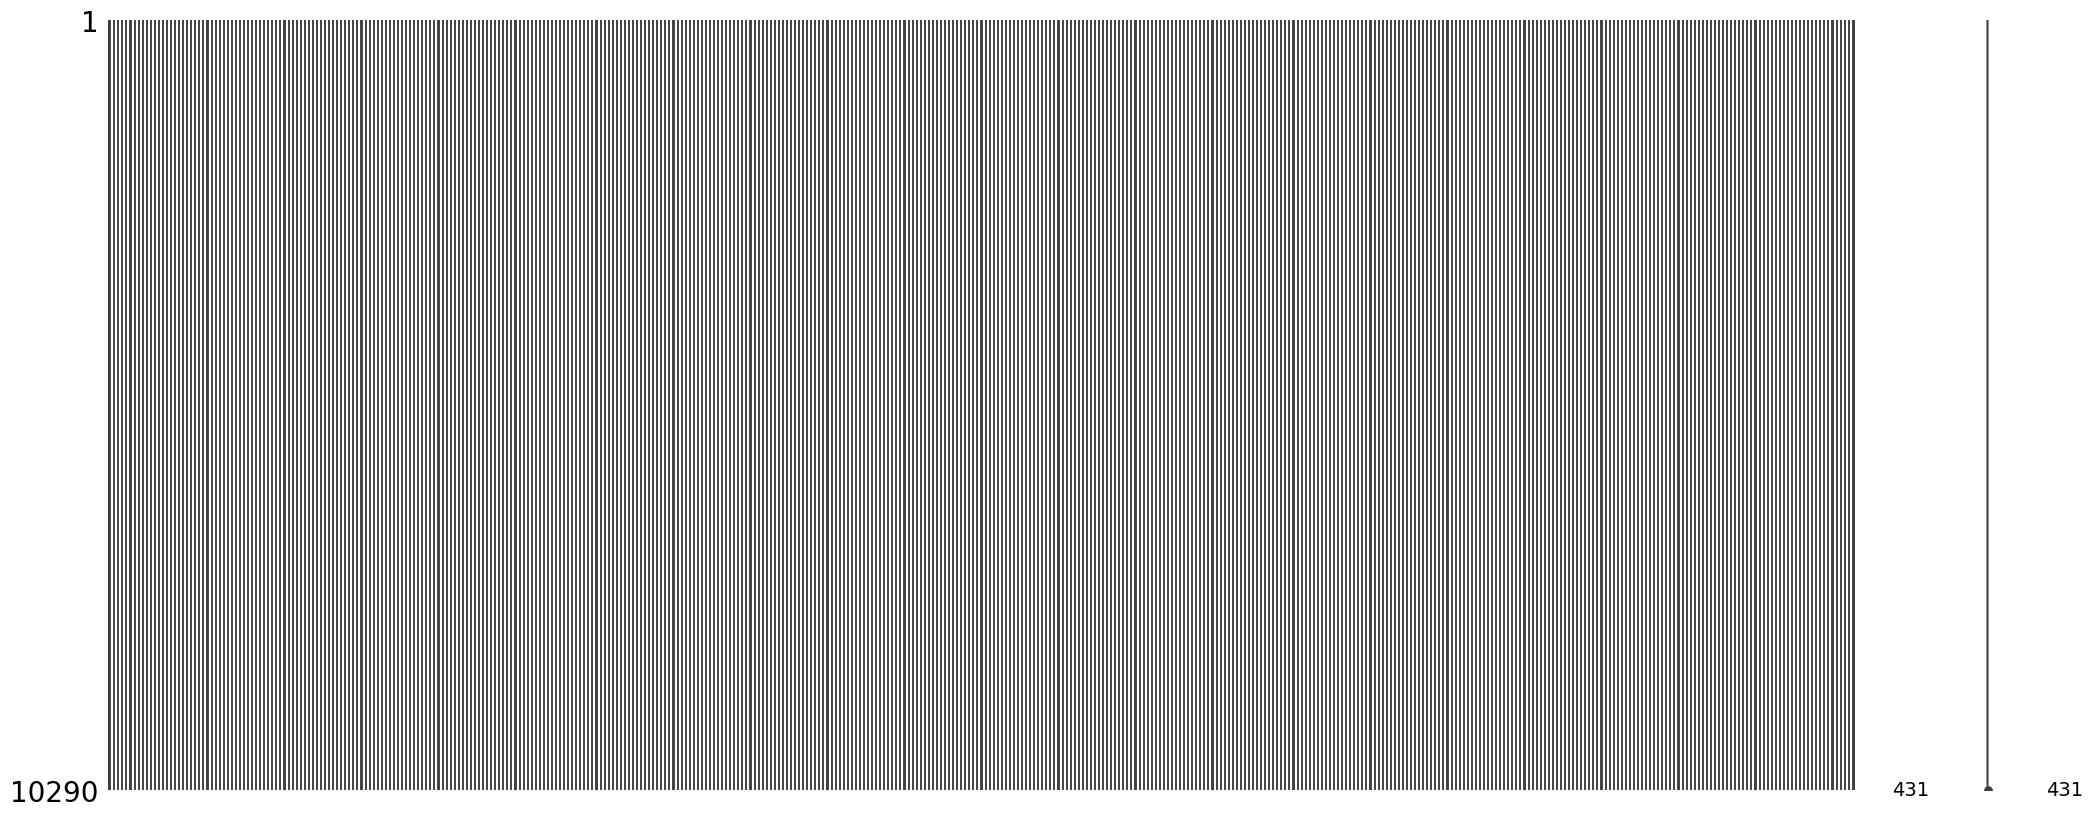

In [4]:
# Extract frequency columns
freq_columns = [col for col in df.columns if col.startswith('F')]

# Function to impute missing values by species
def impute_by_species(df, freq_columns, method='mean'):
    df_imputed = df.copy()
    
    for col in freq_columns:
        # Compute the mean/median of the column for each species
        if method == 'mean':
            impute_values = df.groupby('species')[col].transform(lambda x: x.fillna(x.mean()))
        elif method == 'median':
            impute_values = df.groupby('species')[col].transform(lambda x: x.fillna(x.median()))
        else:
            raise ValueError("Method must be 'mean' or 'median'")
        
        # Assign imputed values
        df_imputed[col] = impute_values

    return df_imputed

# Apply the function
df = impute_by_species(df, freq_columns, method='mean')

# Check if missing values remain
import missingno as msno
msno.matrix(df)
plt.show()

#### 2.2 Time Feature Engineering: Time elapsed since the first ping

In [5]:
df['pingDateTime'] = pd.to_datetime(df['pingDateTime'])
# Calculate time elapsed since the first ping for each fish (in seconds)
# Capture how the fish’s response evolves during the experiment
df['time_elapsed'] = df.groupby('fishNum')['pingDateTime'].transform(
    lambda x: (x - x.min()).dt.total_seconds()
)
features = freq_columns + ['time_elapsed']

/var/folders/r_/ypjqpbh136gdzxvkn9cvg1wh0000gn/T/ipykernel_5361/269528243.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['time_elapsed'] = df.groupby('fishNum')['pingDateTime'].transform(


#### 2.3 Add Frequency-Range Features around F90-F170

In [6]:
# Define frequency range
F_START = 90
F_END = 170

# Get all frequency columns in the range
freq_cols_in_range2 = [col for col in df.columns 
             if (re.match(r'F\d+\.?\d*', col) and 
                 F_START <= float(re.findall(r'\d+\.?\d*', col)[0]) <= F_END)]

def calculate_freq_features(group):
    # Static features
    group['F90_170_mean'] = group[freq_cols_in_range2].mean(axis=1)
    group['F90_170_std'] = group[freq_cols_in_range2].std(axis=1)
    
    # Dynamic features
    fish_mean = group['F90_170_mean'].mean()
    group['F90_170_deviation'] = group['F90_170_mean'] - fish_mean
    group['F90_170_rolling'] = group['F90_170_mean'].rolling(3, min_periods=1).mean()
    
    return group

# Apply to dataframe
df = df.groupby('fishNum', group_keys=False).apply(calculate_freq_features)

# Update features list
features += ['F90_170_mean', 'F90_170_std',
             'F90_170_deviation', 'F90_170_rolling']

/var/folders/r_/ypjqpbh136gdzxvkn9cvg1wh0000gn/T/ipykernel_5361/3973418540.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  group['F90_170_mean'] = group[freq_cols_in_range2].mean(axis=1)
/var/folders/r_/ypjqpbh136gdzxvkn9cvg1wh0000gn/T/ipykernel_5361/3973418540.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  group['F90_170_std'] = group[freq_cols_in_range2].std(axis=1)
/var/folders/r_/ypjqpbh136gdzxvkn9cvg1wh0000gn/T/ipykernel_5361/3973418540.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually t

In [7]:
df

,F45,F45.5,F46,F46.5,F47,F47.5,F48,F48.5,F49,F49.5,...,fishNum,species,Ping_time,dateSample,pingDateTime,time_elapsed,F90_170_mean,F90_170_std,F90_170_deviation,F90_170_rolling
0,-48.850989,-47.481644,-45.900477,-44.184644,-42.970845,-41.691276,-40.599349,-39.570164,-38.581552,-37.671468,...,LT001,lakeTrout,20:58:41.3460,2022-07-21,2022-07-21 20:58:41.346,0.000,-46.096608,3.539569,0.000000,-46.096608
1,-47.374837,-47.585660,-47.124362,-45.489171,-43.606820,-41.616682,-40.115114,-38.952216,-37.989185,-37.155027,...,LT001,lakeTrout,20:58:41.4730,2022-07-21,2022-07-21 20:58:41.473,0.127,-46.096608,3.539569,0.000000,-46.096608
2,-47.870826,-49.341342,-49.339863,-47.152783,-44.901575,-42.735101,-40.998254,-39.533235,-38.270208,-37.192617,...,LT001,lakeTrout,20:58:41.6010,2022-07-21,2022-07-21 20:58:41.601,0.255,-46.096608,3.539569,0.000000,-46.096608
3,-44.326289,-45.714510,-47.617086,-48.788610,-48.555806,-46.698281,-44.686905,-42.949347,-41.513695,-40.306633,...,LT001,lakeTrout,20:58:41.7260,2022-07-21,2022-07-21 20:58:41.726,0.380,-46.096608,3.539569,0.000000,-46.096608
4,-41.437463,-42.339934,-43.594854,-44.653928,-45.868339,-46.605502,-46.938155,-46.679795,-46.015012,-45.137440,...,LT001,lakeTrout,20:58:41.8520,2022-07-21,2022-07-21 20:58:41.852,0.506,-46.096608,3.539569,0.000000,-46.096608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14570,-55.961591,-55.405399,-55.286099,-55.120911,-55.211957,-55.066819,-55.168176,-55.549187,-56.269773,-57.396686,...,SMB013,smallmouthBass,00:49:17.7740,2022-07-28,2022-07-28 00:49:17.774,1194.010,-50.148849,5.746990,-1.257438,-51.728403
14571,-56.105286,-55.245880,-54.790369,-54.391916,-54.368325,-54.129744,-54.031791,-54.049620,-54.227549,-54.632232,...,SMB013,smallmouthBass,00:49:17.9640,2022-07-28,2022-07-28 00:49:17.964,1194.200,-50.911797,7.082743,-2.020386,-51.569773
14572,-53.473647,-53.900070,-54.311638,-54.225860,-54.200046,-53.959463,-53.908809,-53.879121,-53.755593,-53.515934,...,SMB013,smallmouthBass,00:49:18.1640,2022-07-28,2022-07-28 00:49:18.164,1194.400,-49.555011,5.375085,-0.663600,-50.205219
14573,-55.284331,-54.497312,-53.898102,-53.296795,-53.225299,-53.149015,-53.290119,-53.532915,-53.959628,-54.727463,...,SMB013,smallmouthBass,00:49:18.3640,2022-07-28,2022-07-28 00:49:18.364,1194.600,-50.510298,5.623196,-1.618887,-50.325702


#### 2.4 Train-Validation-Test Split by Fish

In [8]:
# # Method 1: Split unique fishNum into train/val/test
# fish_ids = df['fishNum'].unique()
# train_fish, test_fish = train_test_split(fish_ids, test_size=0.2, stratify=df.groupby('fishNum')['species'].first(), random_state=42)
# train_fish, val_fish = train_test_split(train_fish, test_size=0.25, stratify=df[df['fishNum'].isin(train_fish)].groupby('fishNum')['species'].first(), random_state=42)

# # Filter data
# train_df = df[df['fishNum'].isin(train_fish)]
# val_df = df[df['fishNum'].isin(val_fish)]
# test_df = df[df['fishNum'].isin(test_fish)]


# ## Method 2: Split on Individual Data Points
# from sklearn.model_selection import train_test_split

# # First, stratify on species
# train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['species'], random_state=42)
# train_df, val_df = train_test_split(train_df, test_size=0.25, stratify=train_df['species'], random_state=42)


## Method 3: species-aware greedy allocation
# Group fish by species and sort by ping count (descending)
species_groups = df.groupby(['species', 'fishNum']).size().reset_index(name='pings')
species_groups = species_groups.sort_values(by=['species', 'pings'], ascending=[True, False])

# Split into lake trout and smallmouth bass groups
lake_trout = species_groups[species_groups['species'] == 'lakeTrout']
smallmouth = species_groups[species_groups['species'] == 'smallmouthBass']

test_size = 0.15
val_size = 0.15
train_size = 1 - test_size - val_size

# Total pings per species
total_lake_trout = df[df['species'] == 'lakeTrout'].shape[0]
total_smallmouth = df[df['species'] == 'smallmouthBass'].shape[0]

# Target pings per split
lake_trout_targets = {
    'train': total_lake_trout * train_size,
    'val': total_lake_trout * val_size,
    'test': total_lake_trout * test_size
}

smallmouth_targets = {
    'train': total_smallmouth * train_size,
    'val': total_smallmouth * val_size,
    'test': total_smallmouth * test_size
}

def assign_fish(species_group, targets):
    splits = {'train': [], 'val': [], 'test': []}
    current_counts = {'train': 0, 'val': 0, 'test': 0}
    
    for _, row in species_group.iterrows():
        fish = row['fishNum']
        pings = row['pings']
        
        # Find which split needs this fish most
        deficits = {
            split: targets[split] - current_counts[split]
            for split in ['train', 'val', 'test']
        }
        best_split = max(deficits, key=lambda k: deficits[k])
        
        splits[best_split].append(fish)
        current_counts[best_split] += pings
        
    return splits

# Assign lake trout and smallmouth bass separately
lt_splits = assign_fish(lake_trout, lake_trout_targets)
sm_splits = assign_fish(smallmouth, smallmouth_targets)

# Combine splits
train_fish = lt_splits['train'] + sm_splits['train']
val_fish = lt_splits['val'] + sm_splits['val']
test_fish = lt_splits['test'] + sm_splits['test']

train_df = df[df['fishNum'].isin(train_fish)]
val_df = df[df['fishNum'].isin(val_fish)]
test_df = df[df['fishNum'].isin(test_fish)]

# Features & target
X_train, y_train = train_df[features], train_df['species']
X_val, y_val = val_df[features], val_df['species']
X_test, y_test = test_df[features], test_df['species']

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

In [10]:
# Check if fish in train appear in val or test
print(set(train_fish) & set(test_fish))  # Should be empty
print(set(train_fish) & set(val_fish))   # Should be empty
print(set(val_fish) & set(test_fish))    # Should be empty

set()
set()
set()


In [11]:
# Check the species distribution after split
print(train_df['species'].value_counts(normalize=True))
print(val_df['species'].value_counts(normalize=True))
print(test_df['species'].value_counts(normalize=True))

species
lakeTrout         0.70563
smallmouthBass    0.29437
Name: proportion, dtype: float64
species
lakeTrout         0.704799
smallmouthBass    0.295201
Name: proportion, dtype: float64
species
lakeTrout         0.698137
smallmouthBass    0.301863
Name: proportion, dtype: float64


#### 2.5 Handle Class Imbalance: Calculate Class Weighting

In [12]:
# Compute class weights
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(y_train_enc), 
    y=y_train_enc
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
class_weight_dict

{0: np.float64(0.7085871487522106), 1: np.float64(1.6985398021667453)}

#### 2.6 Train Models with Stratified Group K-Fold Cross-Validation

##### 2.5.1 Logistic Regression 

In [20]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import balanced_accuracy_score

# Extract groups (fishNum) and labels
groups = df['fishNum'].values
X = df[features].values
y = df['species'].values

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Initialize cross-validation
sgkf = StratifiedGroupKFold(n_splits=5)  # Adjust splits based on dataset size

# Store scores
test_scores = []

for train_idx, test_idx in sgkf.split(X, y_enc, groups):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_enc[train_idx], y_enc[test_idx]
    
    # Train model (example: RandomForest)
    model = LogisticRegression(
                class_weight='balanced',  
                solver='liblinear')
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class
    
    # Evaluate
    score = balanced_accuracy_score(y_test, y_pred)
    test_scores.append(score)

print(f"Mean balanced accuracy: {np.mean(test_scores):.3f} (±{np.std(test_scores):.3f})")

Mean balanced accuracy: 0.622 (±0.080)


##### 2.5.2 Random Forest

In [22]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import balanced_accuracy_score

# Extract groups (fishNum) and labels
groups = df['fishNum'].values
X = df[features].values
y = df['species'].values

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Initialize cross-validation
sgkf = StratifiedGroupKFold(n_splits=5)  # Adjust splits based on dataset size

# Store scores
test_scores = []
auc_scores, f1_scores = [], []
precision_scores, recall_scores = [], []
conf_matrices = []

for train_idx, test_idx in sgkf.split(X, y_enc, groups):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_enc[train_idx], y_enc[test_idx]
    
    # Train model (example: RandomForest)
    model = RandomForestClassifier(class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class
    
    # Evaluate
    score = balanced_accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # Append to lists
    test_scores.append(score)
    auc_scores.append(auc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    conf_matrices.append(cm)
    
# Aggregate results
print(f"""
=== Cross-Validation Results ===
Mean Balanced Accuracy: {np.mean(test_scores):.3f} (±{np.std(test_scores):.3f})
AUC-ROC: {np.mean(auc_scores):.3f} (±{np.std(auc_scores):.3f})
Precision: {np.mean(precision_scores):.3f} (±{np.std(precision_scores):.3f})
Recall: {np.mean(recall_scores):.3f} (±{np.std(recall_scores):.3f})
F1: {np.mean(f1_scores):.3f} (±{np.std(f1_scores):.3f})
""")


=== Cross-Validation Results ===
Mean Balanced Accuracy: 0.576 (±0.073)
AUC-ROC: 0.749 (±0.111)
Precision: 0.491 (±0.213)
Recall: 0.304 (±0.089)
F1: 0.361 (±0.108)



In [23]:
# K-Fold with Threshold Tuning and Grid Search
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import (
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score,
    roc_auc_score
)

# Hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100],       # Number of trees
    'max_depth': [None, 10],         # Tree depth
    'min_samples_split': [2, 5]      # Minimum samples to split a node
}

# Initialize cross-validation
sgkf_outer = StratifiedGroupKFold(n_splits=5)
sgkf_inner = StratifiedGroupKFold(n_splits=3)

# Store metrics for each fold
test_f1, test_balanced_accuracy = [], []
test_precision, test_recall, test_auc = [], [], []

for train_idx, test_idx in sgkf_outer.split(X, y_enc, groups):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_enc[train_idx], y_enc[test_idx]
    groups_train = groups[train_idx]

    # Inner loop: Hyperparameter + threshold tuning
    best_params = None
    best_threshold = 0.5
    best_score = -np.inf
    
    # Grid search over hyperparameters
    for params in ParameterGrid(param_grid):
        inner_fold_scores = []
        inner_thresholds = []
        
        for inner_train_idx, val_idx in sgkf_inner.split(X_train, y_train, groups_train):
            X_inner_train, X_val = X_train[inner_train_idx], X_train[val_idx]
            y_inner_train, y_val = y_train[inner_train_idx], y_train[val_idx]
            
            # Train with current hyperparameters
            model = RandomForestClassifier(
                **params,
                class_weight='balanced',
                random_state=42
            )
            model.fit(X_inner_train, y_inner_train)
            
            # Tune threshold
            y_val_proba = model.predict_proba(X_val)[:, 1]
            precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
            optimal_idx = np.argmax(f1_scores)
            inner_thresholds.append(thresholds[optimal_idx])
            
            # Predict with optimal threshold
            threshold = np.mean(inner_thresholds)
            y_val_pred = (y_val_proba >= threshold).astype(int)
            score = f1_score(y_val, y_val_pred)
            inner_fold_scores.append(score)
        
        # Average validation F1 across inner folds
        mean_score = np.mean(inner_fold_scores)
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
            best_threshold = np.mean(inner_thresholds)
    
    # Train final model with best params on full training data
    final_model = RandomForestClassifier(
        **best_params,
        class_weight='balanced',
        random_state=42
    )
    final_model.fit(X_train, y_train)

    # Evaluate on test data with best threshold
    y_test_proba = final_model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_proba >= best_threshold).astype(int)
    
    # Compute all metrics
    test_f1.append(f1_score(y_test, y_test_pred))
    test_balanced_accuracy.append(balanced_accuracy_score(y_test, y_test_pred))
    test_precision.append(precision_score(y_test, y_test_pred))
    test_recall.append(recall_score(y_test, y_test_pred))
    test_auc.append(roc_auc_score(y_test, y_test_proba))

# Aggregate results across all folds
print(f"""
=== Test Set Results ===
Mean F1: {np.mean(test_f1):.3f} (±{np.std(test_f1):.3f})
Mean Balanced Accuracy: {np.mean(test_balanced_accuracy):.3f} (±{np.std(test_balanced_accuracy):.3f})
Mean Precision: {np.mean(test_precision):.3f} (±{np.std(test_precision):.3f})
Mean Recall: {np.mean(test_recall):.3f} (±{np.std(test_recall):.3f})
Mean AUC-ROC: {np.mean(test_auc):.3f} (±{np.std(test_auc):.3f})
""")


=== Test Set Results ===
Mean F1: 0.534 (±0.129)
Mean Balanced Accuracy: 0.655 (±0.115)
Mean Precision: 0.432 (±0.142)
Mean Recall: 0.766 (±0.174)
Mean AUC-ROC: 0.759 (±0.115)



##### 2.5.3 XGBoost

In [24]:
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
import numpy as np

# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1],     # Step size shrinkage
    'max_depth': [3, 5],              # Tree depth
    'subsample': [0.8, 1.0],          # Fraction of samples per tree
    'colsample_bytree': [0.8, 1.0],   # Fraction of features per tree
    'n_estimators': [100, 200]        # Number of boosting rounds
}

# Calculate class imbalance ratio
scale_pos_weight = (y_enc == 0).sum() / (y_enc == 1).sum()

# Initialize CV
sgkf = StratifiedGroupKFold(n_splits=5)
inner_cv = StratifiedGroupKFold(n_splits=3)  # For hyperparameter tuning

# Store metrics
test_scores = []
auc_scores, f1_scores = [], []
precision_scores, recall_scores = [], []

for train_idx, test_idx in sgkf.split(X, y_enc, groups):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_enc[train_idx], y_enc[test_idx]
    groups_train = groups[train_idx]
    
    # ========== Hyperparameter Tuning ==========
    grid_search = GridSearchCV(
        estimator=XGBClassifier(
            scale_pos_weight=scale_pos_weight,
            eval_metric='logloss',
            random_state=42
        ),
        param_grid=param_grid,
        cv=inner_cv.split(X_train, y_train, groups_train),  # Group-aware splits
        scoring='f1',        # Optimize for F1 score
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train, y_train)
    
    # Get best model and parameters
    best_model = grid_search.best_estimator_
    print(f"Best params: {grid_search.best_params_}")
    
    # ========== Evaluation ==========
    y_proba = best_model.predict_proba(X_test)[:, 1]
    y_pred = best_model.predict(X_test)
    
    # Append metrics
    test_scores.append(balanced_accuracy_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_proba))
    f1_scores.append(f1_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))

# Aggregate results
print(f"""
=== Cross-Validation Results ===
Mean Balanced Accuracy: {np.mean(test_scores):.3f} (±{np.std(test_scores):.3f})
AUC-ROC: {np.mean(auc_scores):.3f} (±{np.std(auc_scores):.3f})
Precision: {np.mean(precision_scores):.3f} (±{np.std(precision_scores):.3f})
Recall: {np.mean(recall_scores):.3f} (±{np.std(recall_scores):.3f})
F1: {np.mean(f1_scores):.3f} (±{np.std(f1_scores):.3f})
""")

Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}

=== Cross-Validation Results ===
Mean Balanced Accuracy: 0.672 (±0.099)
AUC-ROC: 0.758 (±0.143)
Precision: 0.454 (±0.138)
Recall: 0.668 (±0.152)
F1: 0.537 (±0.140)



## 3. Build deep learning models

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Input, Bidirectional, GRU, Dense, Dropout, BatchNormalization, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Attention

/Users/yingliang/Desktop/FishTetherProject/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### 3.1 Multilayer Perceptron


=== Fold 1 ===
Epoch 1/150
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.7801 - loss: 3.6226 - val_auc: 0.6088 - val_loss: 2.5912 - learning_rate: 0.0010
Epoch 2/150
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8794 - loss: 2.4577 - val_auc: 0.5005 - val_loss: 2.0610 - learning_rate: 0.0010
Epoch 3/150
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9146 - loss: 1.7648 - val_auc: 0.5026 - val_loss: 1.7551 - learning_rate: 0.0010
Epoch 4/150
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9310 - loss: 1.3605 - val_auc: 0.5276 - val_loss: 1.4682 - learning_rate: 0.0010
Epoch 5/150
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - auc: 0.9284 - loss: 1.1610 - val_auc: 0.4437 - val_loss: 1.3100 - learning_rate: 0.0010
Epoch 6/150
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - auc: 0.9383 - loss: 1.0134 - val_auc: 0.3920 - val_loss: 1.4085 - learning_rate: 0.0010
Epoch 7/150
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9476 - loss: 0.8742 - val_auc: 0.5145 - val_loss: 1.2186 - l

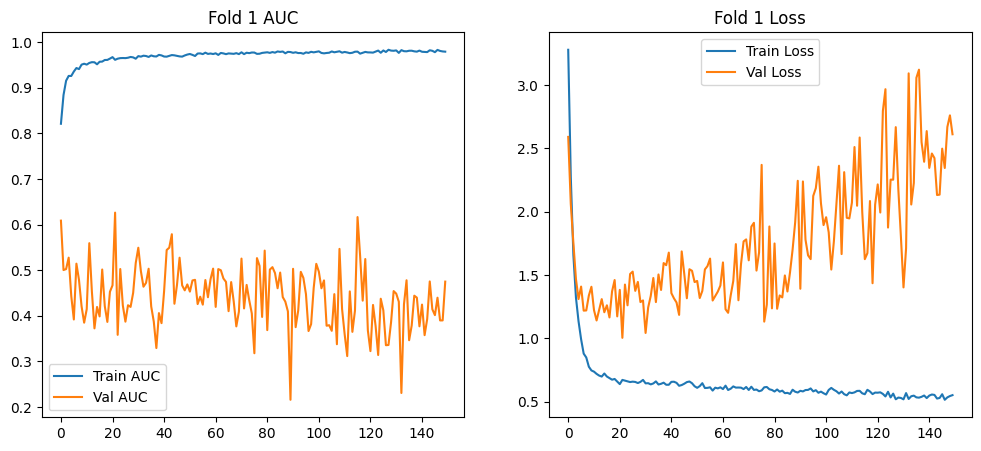


=== Fold 2 ===
Epoch 1/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.7186 - loss: 4.0217 - val_auc: 0.6392 - val_loss: 3.0873 - learning_rate: 0.0010
Epoch 2/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8245 - loss: 3.0525 - val_auc: 0.6755 - val_loss: 2.5384 - learning_rate: 0.0010
Epoch 3/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8597 - loss: 2.4362 - val_auc: 0.7387 - val_loss: 1.9716 - learning_rate: 0.0010
Epoch 4/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8900 - loss: 1.9585 - val_auc: 0.7878 - val_loss: 1.6798 - learning_rate: 0.0010
Epoch 5/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9041 - loss: 1.6441 - val_auc: 0.7411 - val_loss: 1.4372 - learning_rate: 0.0010
Epoch 6/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9121 - loss: 1.4276 - val_auc: 0.7377 - val_loss: 1.2550 - learning_rate: 0.0010
Epoch 7/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9173 - loss: 1.2811 - val_auc: 0.8379 - val_loss: 1.1684 - learning_rate: 0.00

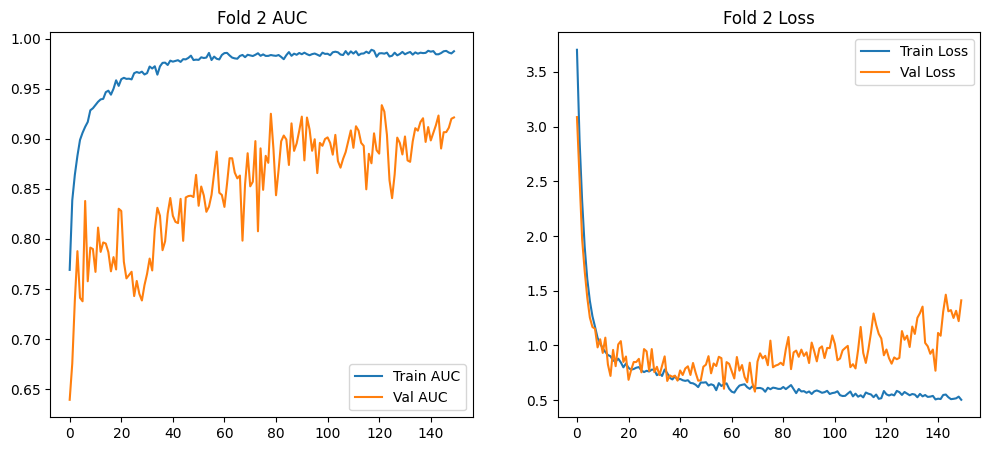


=== Fold 3 ===
Epoch 1/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8143 - loss: 3.7063 - val_auc: 0.1928 - val_loss: 3.2142 - learning_rate: 0.0010
Epoch 2/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - auc: 0.9214 - loss: 2.3311 - val_auc: 0.2372 - val_loss: 2.6097 - learning_rate: 0.0010
Epoch 3/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9421 - loss: 1.5769 - val_auc: 0.3042 - val_loss: 2.1219 - learning_rate: 0.0010
Epoch 4/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - auc: 0.9459 - loss: 1.2254 - val_auc: 0.3985 - val_loss: 1.8267 - learning_rate: 0.0010
Epoch 5/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - auc: 0.9546 - loss: 0.9663 - val_auc: 0.4315 - val_loss: 1.6353 - learning_rate: 0.0010
Epoch 6/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9486 - loss: 0.8900 - val_auc: 0.4225 - val_loss: 1.5765 - learning_rate: 0.0010
Epoch 7/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9579 - loss: 0.7549 - val_auc: 0.3034 - val_loss: 1.8235 -

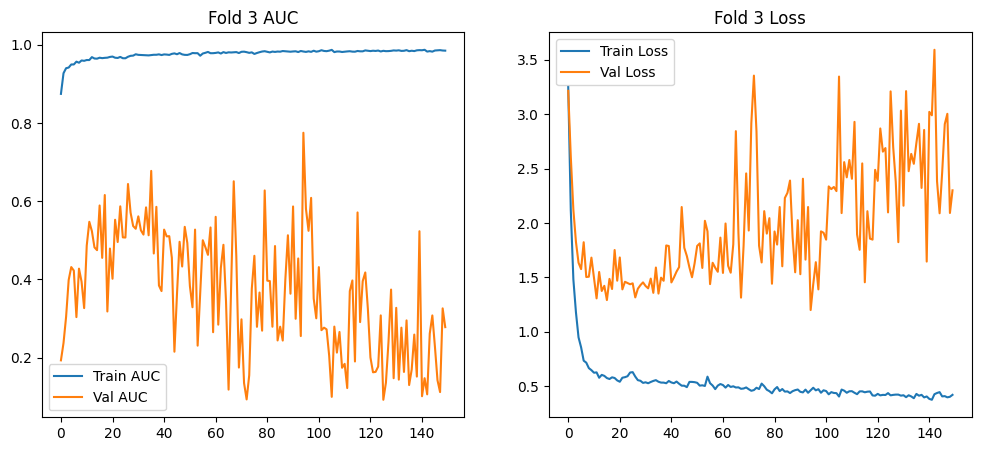


=== Fold 4 ===
Epoch 1/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.7946 - loss: 3.7656 - val_auc: 0.7666 - val_loss: 3.0942 - learning_rate: 0.0010
Epoch 2/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8868 - loss: 2.6864 - val_auc: 0.7484 - val_loss: 2.7712 - learning_rate: 0.0010
Epoch 3/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9164 - loss: 2.0139 - val_auc: 0.7403 - val_loss: 2.3237 - learning_rate: 0.0010
Epoch 4/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9279 - loss: 1.5888 - val_auc: 0.7300 - val_loss: 2.0453 - learning_rate: 0.0010
Epoch 5/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9280 - loss: 1.3593 - val_auc: 0.7141 - val_loss: 1.9693 - learning_rate: 0.0010
Epoch 6/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9328 - loss: 1.1663 - val_auc: 0.7527 - val_loss: 1.5560 - learning_rate: 0.0010
Epoch 7/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9378 - loss: 1.0418 - val_auc: 0.7593 - val_loss: 1.5925 - learning_rate: 0.00

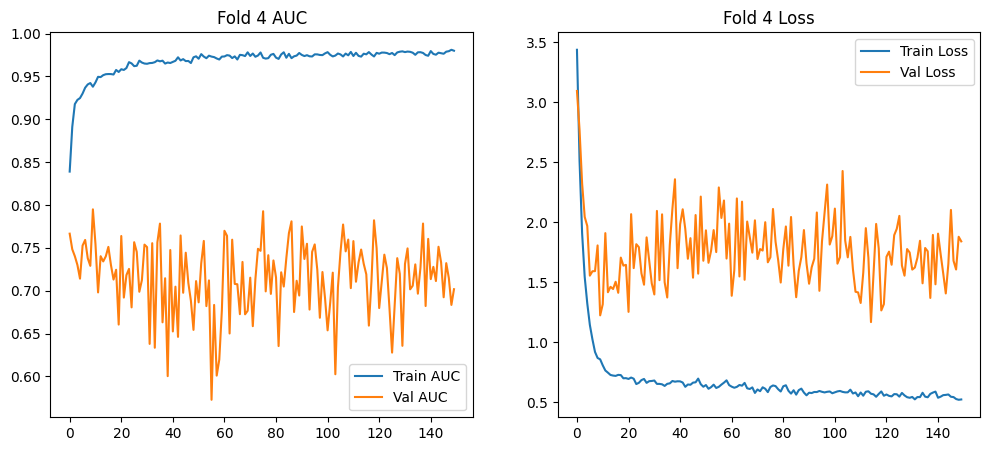


=== Fold 5 ===
Epoch 1/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.7826 - loss: 3.9948 - val_auc: 0.6111 - val_loss: 3.0200 - learning_rate: 0.0010
Epoch 2/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8971 - loss: 2.7323 - val_auc: 0.6538 - val_loss: 2.3282 - learning_rate: 0.0010
Epoch 3/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9173 - loss: 2.0440 - val_auc: 0.6490 - val_loss: 1.7870 - learning_rate: 0.0010
Epoch 4/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9306 - loss: 1.6109 - val_auc: 0.6119 - val_loss: 1.5711 - learning_rate: 0.0010
Epoch 5/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9458 - loss: 1.2860 - val_auc: 0.6383 - val_loss: 1.2611 - learning_rate: 0.0010
Epoch 6/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9417 - loss: 1.1401 - val_auc: 0.5885 - val_loss: 1.2846 - learning_rate: 0.0010
Epoch 7/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9502 - loss: 0.9802 - val_auc: 0.5995 - val_loss: 1.0848 - learning_rate: 0.00

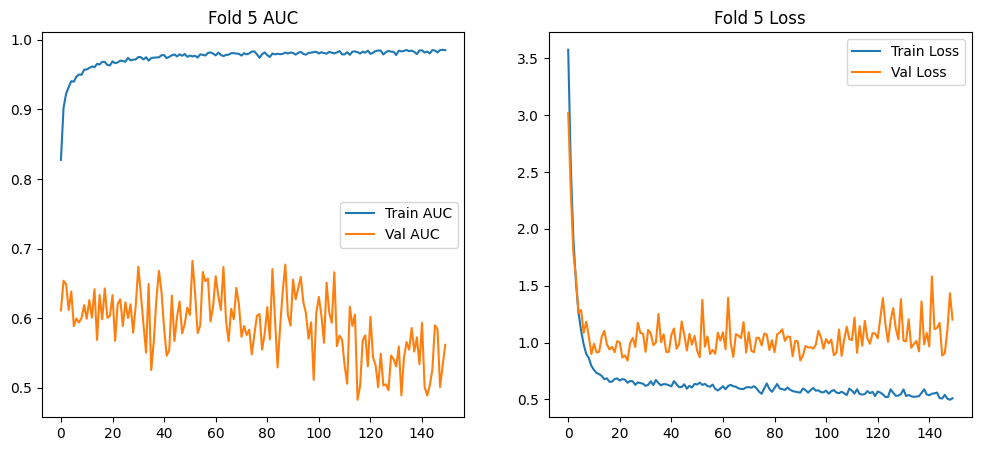


=== Final Test Metrics ===
Auc: 0.684 ± 0.124
Balanced_accuracy: 0.552 ± 0.070
F1_score: 0.400 ± 0.073
Precision: 0.341 ± 0.075
Recall: 0.619 ± 0.313


In [34]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit
from sklearn.metrics import balanced_accuracy_score, f1_score
from tensorflow.keras import layers, models, callbacks

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# =============================================
# Data Preparation
# =============================================
# Group data by fish and sort by time (with include_groups=False to avoid warning)
df_grouped = df.groupby('fishNum', group_keys=False).apply(lambda x: x.sort_values('time_elapsed'))

fish_groups = df_grouped['fishNum'].values
X = df_grouped[features].values
y = df_grouped['species'].values

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)  # 0=Lake Trout, 1=Smallmouth Bass

# =============================================
# Class Weight Calculation
# =============================================
class_counts = np.bincount(y_enc)
total = len(y_enc)
class_weights = {0: 1, 1: 5}  # Start with 5:1 ratio, adjust based on results

# =============================================
# Improved Model Architecture
# =============================================
def create_improved_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu', kernel_regularizer='l2'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(64, activation='relu', kernel_regularizer='l2'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )
    return model

# =============================================
# Training Setup
# =============================================
sgkf = StratifiedGroupKFold(n_splits=5)
test_metrics = []

for fold, (train_idx, test_idx) in enumerate(sgkf.split(X, y_enc, fish_groups)):
    print(f"\n=== Fold {fold+1} ===")
    
    # Split into main train/test
    X_main, X_test = X[train_idx], X[test_idx]
    y_main, y_test = y_enc[train_idx], y_enc[test_idx]
    groups_main = fish_groups[train_idx]

    # =============================================
    # Group-aware validation split
    # =============================================
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx_fold, val_idx_fold in gss.split(X_main, y_main, groups=groups_main):
        X_train, X_val = X_main[train_idx_fold], X_main[val_idx_fold]
        y_train, y_val = y_main[train_idx_fold], y_main[val_idx_fold]
    
    # Verify no group overlap
    train_groups = np.unique(groups_main[train_idx_fold])
    val_groups = np.unique(groups_main[val_idx_fold])
    assert len(np.intersect1d(train_groups, val_groups)) == 0
    
    # =============================================
    # Data Standardization
    # =============================================
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # =============================================
    # Model Initialization
    # =============================================
    model = create_improved_model(X_train_scaled.shape[1:])
    
    # =============================================
    # Callbacks
    # =============================================
    # early_stop = callbacks.EarlyStopping(
    #     monitor='val_auc',
    #     patience=10,
    #     verbose=1,
    #     mode='max',
    #     restore_best_weights=True
    # )
    
    # lr_scheduler = callbacks.ReduceLROnPlateau(
    #     monitor='val_auc',
    #     factor=0.5,
    #     patience=3,
    #     verbose=1,
    #     mode='max'
    # )

    # =============================================
    # Training
    # =============================================
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=150,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[
        callbacks.EarlyStopping(monitor='val_f1_score', patience=15, mode='max'),
        callbacks.ReduceLROnPlateau(monitor='val_f1_score', factor=0.2, patience=7)
    ]
)

    # =============================================
    # Evaluation
    # =============================================
    # Get best threshold from validation data
    val_probs = model.predict(X_val_scaled)
    precisions, recalls, thresholds = precision_recall_curve(y_val, val_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
    best_threshold = thresholds[np.argmax(f1_scores)]

    # Test evaluation
    test_probs = model.predict(X_test_scaled)
    test_preds = (test_probs > best_threshold).astype(int)
    
    # Calculate metrics
    fold_metrics = {
        'auc': roc_auc_score(y_test, test_probs),
        'balanced_accuracy': balanced_accuracy_score(y_test, test_preds),
        'f1_score': f1_score(y_test, test_preds),
        'precision': precision_score(y_test, test_preds),
        'recall': recall_score(y_test, test_preds)
    }
    
    test_metrics.append(fold_metrics)
    
    # =============================================
    # Plot Training Curves
    # =============================================
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title(f'Fold {fold+1} AUC')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold+1} Loss')
    plt.legend()
    plt.show()

# =============================================
# Final Results
# =============================================
print("\n=== Final Test Metrics ===")
for metric in test_metrics[0].keys():
    scores = [fold[metric] for fold in test_metrics]
    print(f"{metric.capitalize()}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

### 3.2 Multi-scale Temporal Model


=== Fold 1 ===
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - auc: 0.5727 - loss: 1.1788 - precision: 0.3000 - recall: 0.6000

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - auc: 0.5727 - loss: 1.1788 - precision: 0.3000 - recall: 0.6000 - val_auc: 0.0000e+00 - val_loss: 1.2669 - val_precision: 0.4000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.6273 - loss: 1.1447 - precision: 0.3333 - recall: 0.6000 - val_auc: 0.0000e+00 - val_loss: 1.2636 - val_precision: 0.4000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.6364 - loss: 1.1687 - precision: 0.4000 - recall: 0.8000 - val_auc: 0.0000e+00 - val_loss: 1.2556 - val_precision: 0.4000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.8000 - loss: 1.1062 - precision: 0.4444 - recall: 0.8000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - auc: 0.8000 - loss: 1.1062 - precision: 0.4444 - recall: 0.8000 - val_auc: 0.1667 - val_loss: 1.2494 - val_precision: 0.4000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.7091 - loss: 1.0996 - precision: 0.3636 - recall: 0.8000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - auc: 0.7091 - loss: 1.0996 - precision: 0.3636 - recall: 0.8000 - val_auc: 0.5833 - val_loss: 1.2369 - val_precision: 0.4000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.7182 - loss: 1.1344 - precision: 0.3333 - recall: 0.8000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - auc: 0.7182 - loss: 1.1344 - precision: 0.3333 - recall: 0.8000 - val_auc: 0.7500 - val_loss: 1.2208 - val_precision: 0.4000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 0.8545 - loss: 1.0633 - precision: 0.4444 - recall: 0.8000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - auc: 0.8545 - loss: 1.0633 - precision: 0.4444 - recall: 0.8000 - val_auc: 0.7500 - val_loss: 1.2119 - val_precision: 0.4000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.6727 - loss: 1.1402 - precision: 0.3000 - recall: 0.6000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - auc: 0.6727 - loss: 1.1402 - precision: 0.3000 - recall: 0.6000 - val_auc: 0.8333 - val_loss: 1.2027 - val_precision: 0.4000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - auc: 0.7455 - loss: 1.1054 - precision: 0.5000 - recall: 0.8000 - val_auc: 0.8333 - val_loss: 1.1918 - val_precision: 0.4000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.7182 - loss: 1.1205 - precision: 0.4444 - recall: 0.8000 - val_auc: 0.8333 - val_loss: 1.1802 - val_precision: 0.4000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - auc: 0.8909 - loss: 1.0393 - precision: 0.5556 - recall: 1.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - auc: 0.8909 - loss: 1.0393 - precision: 0.5556 - recall: 1.0000 - val_auc: 0.9167 - val_loss: 1.1682 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.9091 - loss: 1.0213 - precision: 0.4545 - recall: 1.0000 - val_auc: 0.9167 - val_loss: 1.1562 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.8000 - loss: 1.0629 - precision: 0.5000 - recall: 0.8000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - auc: 0.8000 - loss: 1.0629 - precision: 0.5000 - recall: 0.8000 - val_auc: 0.9167 - val_loss: 1.1474 - val_precision: 0.6667 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - auc: 0.8091 - loss: 1.0593 - precision: 0.5714 - recall: 0.8000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - auc: 0.8091 - loss: 1.0593 - precision: 0.5714 - recall: 0.8000 - val_auc: 1.0000 - val_loss: 1.1351 - val_precision: 0.6667 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.7727 - loss: 1.0477 - precision: 0.3750 - recall: 0.6000 - val_auc: 1.0000 - val_loss: 1.1289 - val_precision: 0.6667 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 16/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.8909 - loss: 1.0105 - precision: 0.5000 - recall: 0.8000 - val_auc: 1.0000 - val_loss: 1.1173 - val_precision: 0.6667 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 17/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.6636 - loss: 1.0595 - precision: 0.6000 - recall: 0.6000 - val_auc: 1.0000 - val_loss: 1.1043 - val_precision: 0.6667 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 18/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.8000 - loss: 1.0726 - precision: 0.5714 - rec

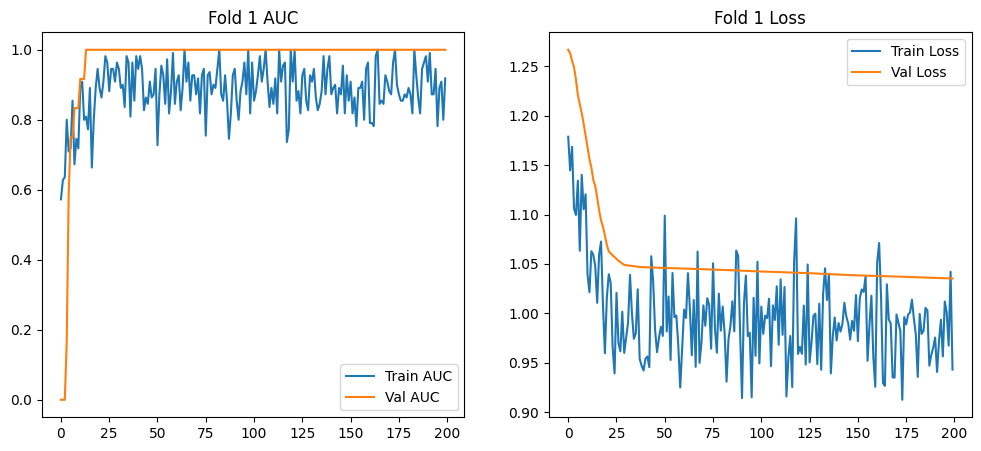


=== Fold 2 ===
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - auc: 0.4455 - loss: 1.3281 - precision: 0.0000e+00 - recall: 0.0000e+00

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - auc: 0.4455 - loss: 1.3281 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 1.2855 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.3091 - loss: 1.4268 - precision: 0.0000e+00 - recall: 0.0000e+00

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - auc: 0.3091 - loss: 1.4268 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.1667 - val_loss: 1.2446 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 0.6273 - loss: 1.2286 - precision: 1.0000 - recall: 0.2000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - auc: 0.6273 - loss: 1.2286 - precision: 1.0000 - recall: 0.2000 - val_auc: 0.3333 - val_loss: 1.2218 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - auc: 0.5636 - loss: 1.2172 - precision: 1.0000 - recall: 0.2000 - val_auc: 0.3333 - val_loss: 1.2073 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.5909 - loss: 1.1976 - precision: 1.0000 - recall: 0.4000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - auc: 0.5909 - loss: 1.1976 - precision: 1.0000 - recall: 0.4000 - val_auc: 0.5833 - val_loss: 1.1871 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - auc: 0.5818 - loss: 1.1832 - precision: 0.6667 - recall: 0.4000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - auc: 0.5818 - loss: 1.1832 - precision: 0.6667 - recall: 0.4000 - val_auc: 0.6667 - val_loss: 1.1775 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.6818 - loss: 1.1764 - precision: 0.5000 - recall: 0.2000 - val_auc: 0.6667 - val_loss: 1.1658 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.7909 - loss: 1.1058 - precision: 0.6000 - recall: 0.6000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - auc: 0.7909 - loss: 1.1058 - precision: 0.6000 - recall: 0.6000 - val_auc: 0.8333 - val_loss: 1.1567 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.6000 - loss: 1.1699 - precision: 1.0000 - recall: 0.4000 - val_auc: 0.8333 - val_loss: 1.1478 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7545 - loss: 1.1313 - precision: 1.0000 - recall: 0.2000 - val_auc: 0.8333 - val_loss: 1.1352 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.8000 - loss: 1.1021 - precision: 0.7500 - recall: 0.6000 - val_auc: 0.8333 - val_loss: 1.1260 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc: 0.7636 - loss: 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - auc: 0.7364 - loss: 1.1071 - precision: 1.0000 - recall: 0.4000 - val_auc: 0.9167 - val_loss: 1.1163 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.7818 - loss: 1.0503 - precision: 1.0000 - recall: 0.4000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - auc: 0.7818 - loss: 1.0503 - precision: 1.0000 - recall: 0.4000 - val_auc: 1.0000 - val_loss: 1.1161 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.9455 - loss: 1.0628 - precision: 1.0000 - recall: 0.8000 - val_auc: 1.0000 - val_loss: 1.1116 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 16/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.8182 - loss: 1.0770 - precision: 0.5000 - recall: 0.4000 - val_auc: 1.0000 - val_loss: 1.1107 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 17/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.8545 - loss: 1.0627 - precision: 0.7500 - recall: 0.6000 - val_auc: 1.0000 - val_loss: 1.1090 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 18/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7455 - loss: 

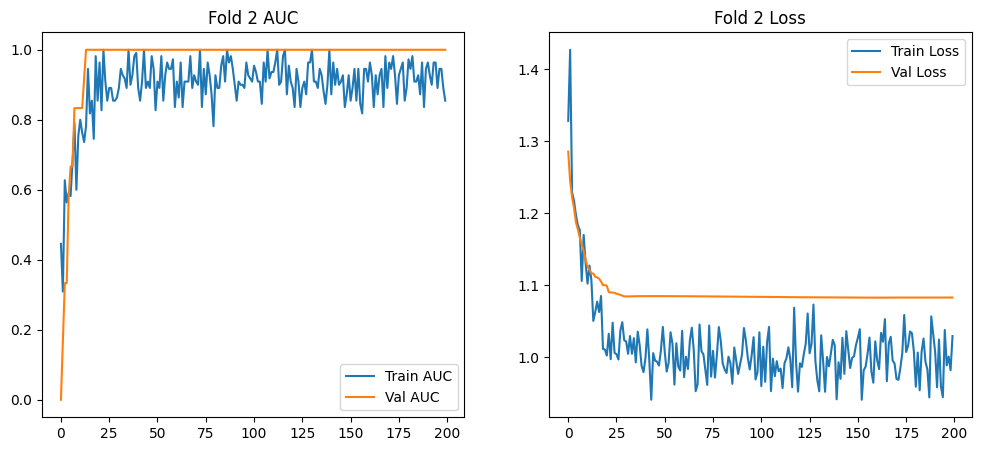


=== Fold 3 ===
Epoch 1/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - auc: 0.4667 - loss: 1.2810 - precision: 0.3077 - recall: 0.6667

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step - auc: 0.4413 - loss: 1.2827 - precision: 0.3407 - recall: 0.6984 - val_auc: 1.0000 - val_loss: 1.3780 - val_precision: 0.2000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc: 0.7418 - loss: 1.1632 - precision: 0.3833 - recall: 0.8571 - val_auc: 1.0000 - val_loss: 1.3394 - val_precision: 0.2000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7630 - loss: 1.1733 - precision: 0.4203 - recall: 1.0000 - val_auc: 1.0000 - val_loss: 1.2880 - val_precision: 0.2000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.9111 - loss: 1.0974 - precision: 0.4778 - recall: 1.0000 - val_auc: 1.0000 - val_loss: 1.2628 - val_precision: 0.2000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.6794 - loss: 1.1506 - precision: 0.3175 - recall

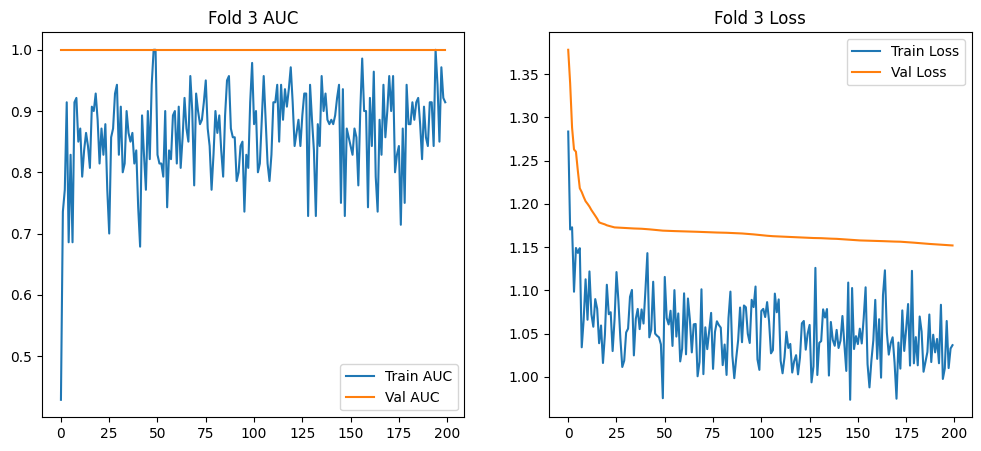


=== Fold 4 ===
Epoch 1/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - auc: 0.2000 - loss: 1.2971 - precision: 0.1111 - recall: 0.1667

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - auc: 0.1879 - loss: 1.2894 - precision: 0.1037 - recall: 0.1667 - val_auc: 0.7500 - val_loss: 1.1877 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.3836 - loss: 1.2258 - precision: 0.3953 - recall: 0.8333 - val_auc: 0.7500 - val_loss: 1.1851 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.5939 - loss: 1.1764 - precision: 0.3929 - recall: 0.5000 - val_auc: 0.7500 - val_loss: 1.1610 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.8364 - loss: 1.1077 - precision: 0.5000 - recall: 0.6000

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - auc: 0.8545 - loss: 1.1033 - precision: 0.5476 - recall: 0.6444 - val_auc: 1.0000 - val_loss: 1.1550 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7260 - loss: 1.1440 - precision: 0.4167 - recall: 0.8333 - val_auc: 0.7500 - val_loss: 1.1444 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.9192 - loss: 1.0578 - precision: 0.6250 - recall: 0.8889 - val_auc: 1.0000 - val_loss: 1.1320 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.9374 - loss: 1.1104 - precision: 0.5455 - recall: 1.0000 - val_auc: 1.0000 - val_loss: 1.1207 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.9354 - loss: 1.0521 - precision: 0.6528 -

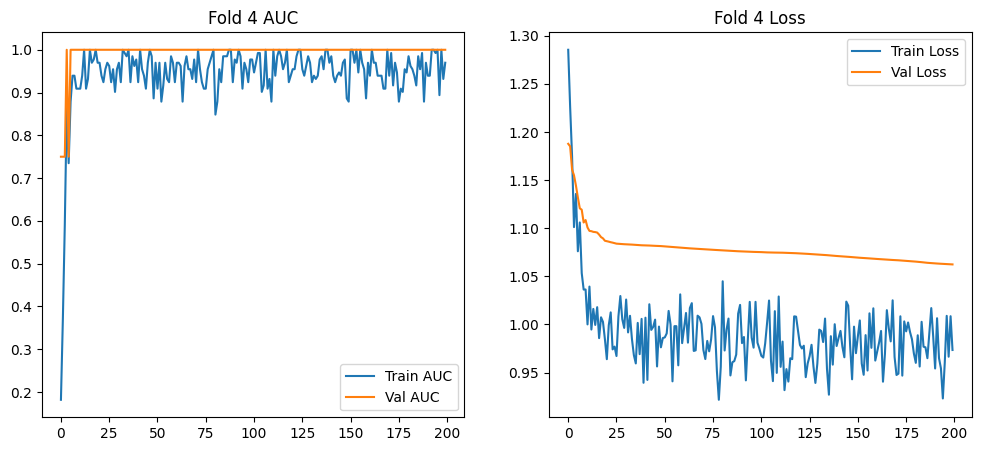


=== Fold 5 ===
Epoch 1/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - auc: 0.4545 - loss: 1.2972 - precision: 0.0000e+00 - recall: 0.0000e+00

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step - auc: 0.4141 - loss: 1.3616 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.2500 - val_loss: 1.0770 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - auc: 0.2727 - loss: 1.3960 - precision: 0.0000e+00 - recall: 0.0000e+00

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.2424 - loss: 1.4698 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.5000 - val_loss: 1.0673 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.6828 - loss: 1.2315 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.5000 - val_loss: 1.0572 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.6455 - loss: 1.2840 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.5000 - val_loss: 1.0602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.6667 - loss: 1.3366 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.5000 - val_loss: 1.0635 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms

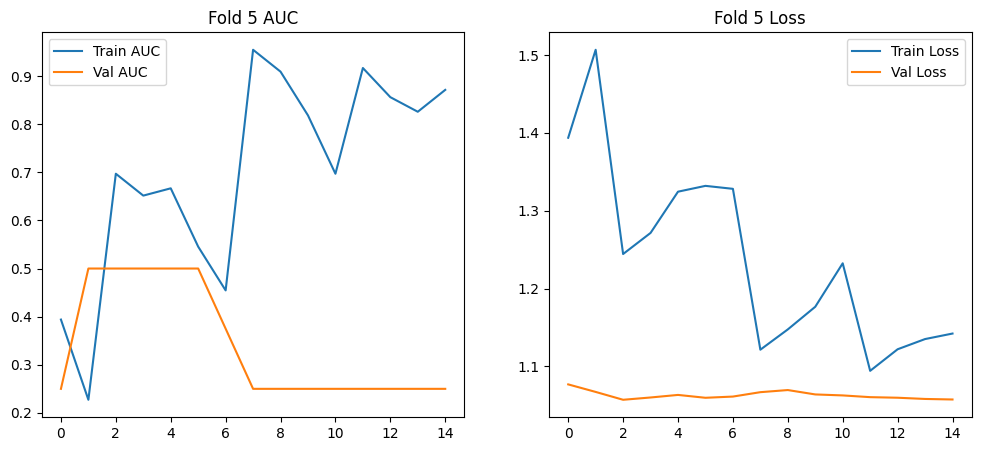


=== Final Test Metrics ===
Auc: 0.967 ± 0.067
Balanced_accuracy: 0.800 ± 0.245
F1_score: 0.714 ± 0.394
Precision: 0.680 ± 0.412
Recall: 0.800 ± 0.400

Optimal Thresholds per Fold:
Fold 1: 0.574
Fold 2: 0.409
Fold 3: 0.602
Fold 4: 0.590
Fold 5: 0.272


In [48]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit
from sklearn.metrics import (balanced_accuracy_score, f1_score, 
                           roc_auc_score, precision_score, 
                           recall_score, precision_recall_curve)
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# =============================================
# Enhanced Data Preparation
# =============================================
# Group data by fish and create sequences
grouped = df.groupby('fishNum', group_keys=False)
sequences = []
labels = []
fish_ids = []

for fish_num, group in grouped:
    seq = group.sort_values('time_elapsed')[features].values
    sequences.append(seq)
    labels.append(group['species'].iloc[0])  # All time points share species
    fish_ids.append(fish_num)

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(labels)  # 0=Lake Trout, 1=Smallmouth Bass
fish_ids = np.array(fish_ids)

# Class-aware sequence trimming
MAX_LENGTH = 300
MIN_LENGTH = 50

filtered_sequences = []
filtered_labels = []
filtered_ids = []

for seq, label, fish_id in zip(sequences, y_enc, fish_ids):
    if MIN_LENGTH <= len(seq) <= MAX_LENGTH:
        filtered_sequences.append(seq)
        filtered_labels.append(label)
        filtered_ids.append(fish_id)
    elif len(seq) > MAX_LENGTH:
        # Preserve middle 50% which often contains key behaviors
        start = len(seq) // 4
        filtered_sequences.append(seq[start:start+MAX_LENGTH])
        filtered_labels.append(label)
        filtered_ids.append(fish_id)

# Pad sequences with class-specific lengths
class_0_length = int(np.percentile([len(s) for s, l in zip(filtered_sequences, filtered_labels) if l == 0], 75))
class_1_length = int(np.percentile([len(s) for s, l in zip(filtered_sequences, filtered_labels) if l == 1], 75))

X_padded = []
for seq, label in zip(filtered_sequences, filtered_labels):
    target_length = class_0_length if label == 0 else class_1_length
    if len(seq) < target_length:
        pad_value = np.mean([s[-1] for s, l in zip(filtered_sequences, filtered_labels) 
                         if (len(s) >= 2 and l == label)])
        padded_seq = np.pad(seq, ((0, target_length - len(seq)), (0, 0)), 
                       'constant', constant_values=pad_value)
    else:
        padded_seq = seq[:target_length]
    X_padded.append(padded_seq)

# Ensure uniform length for numpy array conversion
final_length = max(len(seq) for seq in X_padded)
X_padded_uniform = np.zeros((len(X_padded), final_length, len(features)))

for i, seq in enumerate(X_padded):
    seq_length = len(seq)
    if seq_length < final_length:
        X_padded_uniform[i] = np.pad(seq, ((0, final_length - seq_length), (0, 0)), 
                             mode='constant')
    else:
        X_padded_uniform[i] = seq[:final_length]

X_padded = X_padded_uniform
y_enc = np.array(filtered_labels)
fish_ids = np.array(filtered_ids)

# =============================================
# Enhanced Model Architecture
# =============================================
def create_temporal_model(input_shape):
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # Masking layer
    x = layers.Masking(mask_value=0.)(inputs)
    
    # Multi-scale temporal processing
    # Branch 1: Short-term patterns
    branch1 = layers.Conv1D(32, 3, activation='relu', padding='same')(x)
    branch1 = layers.MaxPooling1D(2)(branch1)
    branch1 = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(branch1)
    
    # Branch 2: Long-term patterns
    branch2 = layers.Conv1D(32, 5, activation='relu', padding='same')(x)
    branch2 = layers.MaxPooling1D(2)(branch2)
    branch2 = layers.Bidirectional(layers.GRU(32, return_sequences=True))(branch2)
    
    # Merge branches
    merged = layers.Concatenate()([branch1, branch2])
    
    # Attention mechanism
    attention = layers.Attention()([merged, merged])
    x = layers.GlobalAveragePooling1D()(attention)
    
    # Classifier with regularization
    x = layers.Dense(32, activation='relu', kernel_regularizer='l2')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    return model

# =============================================
# Custom Callbacks
# =============================================
class ValidationStabilizer(callbacks.Callback):
    def __init__(self, patience=10, min_auc=0.65):
        super().__init__()
        self.patience = patience
        self.wait = 0
        self.min_auc = min_auc
        
    def on_epoch_end(self, epoch, logs=None):
        current_auc = logs.get('val_auc')
        if current_auc >= self.min_auc:
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True
                print(f"\nEarly stopping: val_auc < {self.min_auc} for {self.patience} epochs")

# =============================================
# Training Pipeline
# =============================================
sgkf = StratifiedGroupKFold(n_splits=5)
test_metrics = []

for fold, (train_idx, test_idx) in enumerate(sgkf.split(X_padded, y_enc, fish_ids)):
    print(f"\n=== Fold {fold+1} ===")
    
    # Split into main train/test
    X_train, X_test = X_padded[train_idx], X_padded[test_idx]
    y_train, y_test = y_enc[train_idx], y_enc[test_idx]
    train_fish_ids = fish_ids[train_idx]

    # Create validation split maintaining group integrity
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx_fold, val_idx_fold in gss.split(X_train, y_train, groups=train_fish_ids):
        X_tr = X_train[train_idx_fold]
        y_tr = y_train[train_idx_fold]
        X_val = X_train[val_idx_fold]
        y_val = y_train[val_idx_fold]
    
    # Feature Scaling (time-step aware)
    scaler = StandardScaler()
    X_tr_flat = X_tr.reshape(-1, X_tr.shape[-1])
    X_val_flat = X_val.reshape(-1, X_val.shape[-1])
    X_test_flat = X_test.reshape(-1, X_test.shape[-1])
    
    scaler.fit(X_tr_flat)
    
    X_tr_scaled = scaler.transform(X_tr_flat).reshape(X_tr.shape)
    X_val_scaled = scaler.transform(X_val_flat).reshape(X_val.shape)
    X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)
    
    # Class weights
    class_counts = np.bincount(y_tr)
    total = len(y_tr)
    class_weights = {
        0: (1 / class_counts[0]) * (total / 2.0),
        1: (1 / class_counts[1]) * (total / 2.0)
    }
    
    # Model initialization
    model = create_temporal_model((X_tr_scaled.shape[1], X_tr_scaled.shape[2]))
    
    # Callbacks
    callbacks_list = [
        ValidationStabilizer(patience=15, min_auc=0.65),
        callbacks.ReduceLROnPlateau(
            monitor='val_auc',
            factor=0.2,
            patience=8,
            mode='max',
            min_lr=1e-6
        ),
        callbacks.ModelCheckpoint(
            f'best_model_fold{fold+1}.h5',
            monitor='val_auc',
            save_best_only=True,
            mode='max'
        )
    ]
    
    # Training
    history = model.fit(
        X_tr_scaled, y_tr,
        validation_data=(X_val_scaled, y_val),
        epochs=200,
        batch_size=16,
        class_weight=class_weights,
        callbacks=callbacks_list,
        verbose=1
    )
    
    # Find optimal threshold from validation data
    val_probs = model.predict(X_val_scaled).flatten()
    precisions, recalls, thresholds = precision_recall_curve(y_val, val_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    
    # Evaluation
    test_probs = model.predict(X_test_scaled).flatten()
    test_preds = (test_probs >= optimal_threshold).astype(int)
    
    fold_metrics = {
        'auc': roc_auc_score(y_test, test_probs),
        'balanced_accuracy': balanced_accuracy_score(y_test, test_preds),
        'f1_score': f1_score(y_test, test_preds),
        'precision': precision_score(y_test, test_preds),
        'recall': recall_score(y_test, test_preds),
        'threshold': optimal_threshold
    }
    test_metrics.append(fold_metrics)
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title(f'Fold {fold+1} AUC')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold+1} Loss')
    plt.legend()
    plt.show()

# =============================================
# Final Evaluation
# =============================================
print("\n=== Final Test Metrics ===")
for metric in test_metrics[0].keys():
    if metric == 'threshold': continue  # Don't average thresholds
    scores = [fold[metric] for fold in test_metrics]
    print(f"{metric.capitalize()}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

print("\nOptimal Thresholds per Fold:")
for i, fold in enumerate(test_metrics):
    print(f"Fold {i+1}: {fold['threshold']:.3f}")